# MLP神经网络分类器训练

本notebook训练MLP（多层感知器）分类器，使用样本权重处理类别不平衡问题。

**前提条件**: 需要先运行数据预处理notebooks（01-03）

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier  # 确保正确导入
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

## 1. 加载和预处理数据

In [6]:
# 加载数据
df = pd.read_csv('/Users/mading1/QuantitativeBiology/cytodata_2019_orig_challenge_data/training_data.csv')

# 排除元信息和标签列，保留特征
meta_cols = ['cell_code', 'cell_id', 'plate', 'replicate', 'well', 'field']
feature_cols = [col for col in df.columns if col not in meta_cols + ['target']]
X = df[feature_cols]
y = df['target']

# 检查并处理缺失值
if X.isnull().any().any():
    print("特征数据包含缺失值，已用均值填充。")
    X = X.fillna(X.mean())
if y.isnull().any():
    print("目标数据包含缺失值，已移除对应行。")
    valid_indices = ~y.isnull()
    X = X[valid_indices]
    y = y[valid_indices]

# 检查目标变量类型并进行标签编码
print(f"目标变量类型: {y.dtype}")
print(f"唯一标签: {y.unique()}")

# 如果目标变量是字符串类型，进行标签编码
if y.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print(f"标签编码后的唯一值: {np.unique(y)}")

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# PCA降维
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")
print(f"原始特征数: {X_train_raw.shape[1]}")
print(f"PCA后特征数: {X_train.shape[1]}")
print(f"保留的方差比例: {pca.explained_variance_ratio_.sum():.4f}")

目标变量类型: object
唯一标签: ['adrenoceptor' 'AMPA' 'Tubulin' 'ROCK' 'DNA_intercalation' 'TopoII'
 'cMyc' 'MEK' 'dopaminereceptor' 'CDK' 'EGFR' 'Ca2' 'DNAMetabolism'
 'cellcycle' 'rac1' 'Cdc25' 'eNOS']
标签编码后的唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
训练集形状: (41013, 20)
测试集形状: (10254, 20)
原始特征数: 116
PCA后特征数: 20
保留的方差比例: 0.9546


## 2. 计算样本权重（处理类别不平衡）

In [7]:
# 使用balanced策略自动计算样本权重
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

print(f"权重范围: {sample_weights.min():.3f} - {sample_weights.max():.3f}")
print(f"权重比例: {sample_weights.max() / sample_weights.min():.2f}:1")

权重范围: 0.588 - 4.355
权重比例: 7.41:1


## 3. 训练模型

In [8]:
# 创建并训练MLP分类器
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=1000,
    random_state=1,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    batch_size=256,
    alpha=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    tol=1e-4
)

# 验证输入数据和样本权重
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train type: {y_train.dtype}")
print(f"sample_weights shape: {sample_weights.shape}")
print(f"sample_weights type: {type(sample_weights)}")

try:
    mlp.fit(X_train, y_train, sample_weight=sample_weights)
    print("模型训练完成！")
    print(f"实际迭代次数: {mlp.n_iter_}")
except ValueError as ve:
    print(f"训练出错: {ve}")
    print("尝试不使用样本权重...")
    mlp = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        max_iter=1000,
        random_state=1,
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        batch_size=256,
        alpha=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        tol=1e-4
    )
    mlp.fit(X_train, y_train)
    print("使用不加权完成训练")
except Exception as e:
    print(f"训练出错: {e}")
    print("尝试不使用样本权重...")
    mlp = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        max_iter=1000,
        random_state=1,
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        batch_size=256,
        alpha=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        tol=1e-4
    )
    mlp.fit(X_train, y_train)
    print("使用不加权完成训练")

X_train shape: (41013, 20)
y_train shape: (41013,)
y_train type: int64
sample_weights shape: (41013,)
sample_weights type: <class 'numpy.ndarray'>
模型训练完成！
实际迭代次数: 37
模型训练完成！
实际迭代次数: 37


### 可选：更强正则与较小网络快速重训
运行此单元将覆盖当前 `mlp`，用于对比更强正则与较小网络的效果。

In [9]:
# 更强正则与较小网络（可选对比）
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=800,
    random_state=1,
    learning_rate='adaptive',
    learning_rate_init=5e-4,
    batch_size=256,
    alpha=1e-3,  # 更强L2正则
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    tol=1e-4
)

mlp.fit(X_train, y_train, sample_weight=sample_weights)
print("重训完成（更强正则）")
print(f"实际迭代次数: {mlp.n_iter_}")

重训完成（更强正则）
实际迭代次数: 43


### 可选：超参数搜索（macro F1）
用少量迭代找一组更好的MLP超参数，搜索结束会将 `mlp` 置为最优模型。

In [10]:
# 轻量随机搜索（运行时间取决于资源，可调 n_iter）
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "hidden_layer_sizes": [(256, 128), (128, 64), (256,), (128,)],
    "alpha": [1e-4, 5e-4, 1e-3],
    "learning_rate_init": [1e-3, 5e-4],
    "batch_size": [128, 256],
}

base_mlp = MLPClassifier(
    max_iter=600,
    random_state=1,
    learning_rate='adaptive',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    tol=1e-4
)

search = RandomizedSearchCV(
    estimator=base_mlp,
    param_distributions=param_dist,
    n_iter=8,
    scoring="f1_macro",
    cv=3,
    random_state=1,
    verbose=1,
    n_jobs=-1,
)

search.fit(X_train, y_train, sample_weight=sample_weights)
print("最优参数:", search.best_params_)
print("最优CV得分 (macro F1):", search.best_score_)

mlp = search.best_estimator_
print("已将 mlp 置为最优模型，可直接运行评估单元。")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
最优参数: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64), 'batch_size': 128, 'alpha': 0.0001}
最优CV得分 (macro F1): 0.3306259361470984
已将 mlp 置为最优模型，可直接运行评估单元。
最优参数: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64), 'batch_size': 128, 'alpha': 0.0001}
最优CV得分 (macro F1): 0.3306259361470984
已将 mlp 置为最优模型，可直接运行评估单元。


## 4. 评估模型


In [11]:
# 预测
y_pred = mlp.predict(X_test)

# 评估
print('=' * 60)
print('模型评估结果')
print('=' * 60)
print(f'准确率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}')
print(f'Macro F1-score: {f1_score(y_test, y_pred, average="macro"):.4f}')
print(f'Weighted F1-score: {f1_score(y_test, y_pred, average="weighted"):.4f}')
print('\n分类报告:')
print(classification_report(y_test, y_pred))
print('\n混淆矩阵:')
print(confusion_matrix(y_test, y_pred))


模型评估结果
准确率 (Accuracy): 0.2449
Macro F1-score: 0.3085
Weighted F1-score: 0.2384

分类报告:
              precision    recall  f1-score   support

           0       0.11      0.15      0.13       765
           1       0.15      0.21      0.18       731
           2       0.36      0.56      0.44       433
           3       0.40      0.77      0.53       138
           4       0.65      0.44      0.52       584
           5       0.12      0.13      0.13       767
           6       0.09      0.01      0.03      1014
           7       0.26      0.55      0.36       506
           8       0.21      0.24      0.22       986
           9       0.59      0.37      0.45       711
          10       0.58      0.30      0.40       652
          11       0.07      0.04      0.05       770
          12       0.03      0.13      0.05       255
          13       0.08      0.08      0.08       486
          14       0.19      0.09      0.12      1027
          15       0.57      0.73      0.64      

## 6. 模型性能评估

=== 核心评估指标 ===
准确率 (Accuracy): 0.2449
精确率 (Precision): 0.2646
召回率 (Recall): 0.2449
F1分数: 0.2384

=== 详细分类报告 ===
              precision    recall  f1-score   support

           0       0.11      0.15      0.13       765
           1       0.15      0.21      0.18       731
           2       0.36      0.56      0.44       433
           3       0.40      0.77      0.53       138
           4       0.65      0.44      0.52       584
           5       0.12      0.13      0.13       767
           6       0.09      0.01      0.03      1014
           7       0.26      0.55      0.36       506
           8       0.21      0.24      0.22       986
           9       0.59      0.37      0.45       711
          10       0.58      0.30      0.40       652
          11       0.07      0.04      0.05       770
          12       0.03      0.13      0.05       255
          13       0.08      0.08      0.08       486
          14       0.19      0.09      0.12      1027
          15       0.57

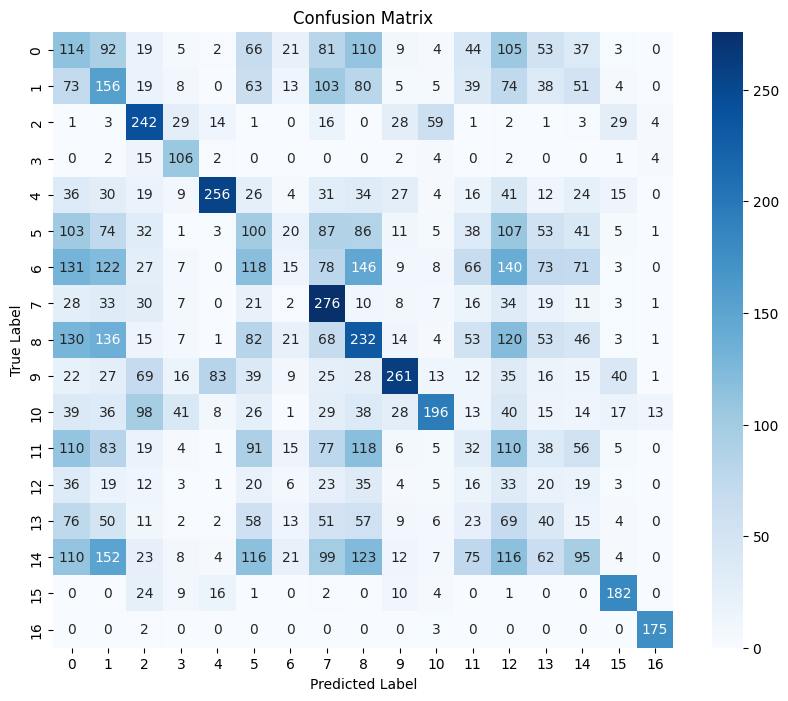


=== 每个类别的详细性能 ===
类别 0:
  精确率: 0.1130
  召回率: 0.1490
  F1分数: 0.1285

类别 1:
  精确率: 0.1537
  召回率: 0.2134
  F1分数: 0.1787

类别 2:
  精确率: 0.3580
  召回率: 0.5589
  F1分数: 0.4364

类别 3:
  精确率: 0.4046
  召回率: 0.7681
  F1分数: 0.5300

类别 4:
  精确率: 0.6514
  召回率: 0.4384
  F1分数: 0.5241

类别 5:
  精确率: 0.1208
  召回率: 0.1304
  F1分数: 0.1254

类别 6:
  精确率: 0.0932
  召回率: 0.0148
  F1分数: 0.0255

类别 7:
  精确率: 0.2639
  召回率: 0.5455
  F1分数: 0.3557

类别 8:
  精确率: 0.2115
  召回率: 0.2353
  F1分数: 0.2228

类别 9:
  精确率: 0.5892
  召回率: 0.3671
  F1分数: 0.4523

类别 10:
  精确率: 0.5782
  召回率: 0.3006
  F1分数: 0.3956

类别 11:
  精确率: 0.0721
  召回率: 0.0416
  F1分数: 0.0527

类别 12:
  精确率: 0.0321
  召回率: 0.1294
  F1分数: 0.0514

类别 13:
  精确率: 0.0811
  召回率: 0.0823
  F1分数: 0.0817

类别 14:
  精确率: 0.1908
  召回率: 0.0925
  F1分数: 0.1246

类别 15:
  精确率: 0.5670
  召回率: 0.7309
  F1分数: 0.6386

类别 16:
  精确率: 0.8750
  召回率: 0.9722
  F1分数: 0.9211



In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 首先进行预测
y_pred = mlp.predict(X_test)

# 核心评估指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("=== 核心评估指标 ===")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1分数: {f1:.4f}")

# 详细分类报告
print("\n=== 详细分类报告 ===")
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=np.unique(y_test), 
           yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 每个类别的性能指标
print("\n=== 每个类别的详细性能 ===")
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

unique_labels = np.unique(y_test)
for i, label in enumerate(unique_labels):
    print(f"类别 {label}:")
    print(f"  精确率: {precision_per_class[i]:.4f}")
    print(f"  召回率: {recall_per_class[i]:.4f}")
    print(f"  F1分数: {f1_per_class[i]:.4f}")
    print()